### **I. Installation & Downloads**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

### For tracking carbon emissions
%pip install codecarbon
from codecarbon import EmissionsTracker

### For cluster analysis
%pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.4 MB/s eta 0:00:00


In [ ]:
### Access the google drive folder via google colab

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Load the data

file_path = '/content/drive/My Drive/[ML Project] Energy'
recs = pd.read_csv(f'{file_path}/1_Data/RECS_2020 (CLEANED).csv')

### **II. Cluster analysis: K-prototypes**

In [ ]:
### Instantiate carbon tracker (for transparency & reporting purposes)

tracker = EmissionsTracker()
tracker.start()

[codecarbon WARNING @ 03:43:15] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 03:43:15] [setup] RAM Tracking...
[codecarbon INFO @ 03:43:15] [setup] GPU Tracking...
[codecarbon INFO @ 03:43:15] No GPU found.
[codecarbon INFO @ 03:43:15] [setup] CPU Tracking...
[codecarbon WARNING @ 03:43:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 03:43:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 03:43:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 03:43:17] >>> Tracker's metadata:
[codecarbon INFO @ 03:43:17]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:43:17]   Python version: 3.10.12
[codecarbon INFO @ 03:43:17]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 03:43:17]   Available RAM : 12.675 GB
[codecarbon INFO @ 03:43:17]   CPU count: 2
[codecarbon INFO @ 03:43:17]   CP

**A. Standardization**

**Rationale for standardizing numeric variables:**

* Distance-based algorithms such as k-means (which is part of k-prototypes) use euclidean distance between data points to determine their similarity.
* If variables are measured along different scales, features with larger variance will be given higher weight in distance calculations. Thus scaling the data is necessary

In [ ]:
# Initialize the standard scaler
scaler = StandardScaler()

# Identify numeric columns
numeric_variables = list(recs.select_dtypes(include = [np.number]))

# Identify categorical columns and their indices
categorical_variables = list(recs.select_dtypes(exclude = [np.number]))
categorical_indices = [recs.columns.get_loc(column) for column in categorical_variables]

# Convert 'object' type variables (categorical) to 'category'
recs[categorical_variables] = recs[categorical_variables].astype('category')

# Standardize the numeric columns & store the output in a separate dataframe
RECS = recs.copy()
RECS[numeric_variables] = scaler.fit_transform(RECS[numeric_variables])

# Rearrange the order of the columns so that it is identical to the original dataset
RECS = RECS[recs.columns]
RECS.head(3)

,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_USAGE,TOTAL_AREA,DRAFTY,INCOME,ENERGY_INSECURE,EDUCATION,RACE_ETHNIC,HOUSEHOLD_SIZE
0,-0.166029,0.120239,1.620206,0.305007,Drafty,Middle,Non energy-insecure,Bachelor's degree or higher,White (Non-Hispanic),-0.320146
1,-0.199775,-0.071538,-1.176228,-1.329164,Drafty,Low,Non energy-insecure,No Bachelor's degree,White (Non-Hispanic),-1.055005
2,-0.176845,0.134991,-1.111119,-0.993672,Tight-sealed,Low,Non energy-insecure,Bachelor's degree or higher,White (Non-Hispanic),-1.055005


**B. Selecting the optimal number of clusters (`k`)**

***K-prototypes:***
* A clustering algorithm for mixed data types
* The cost function for
  * **Numeric attributes:** sum of squared distances between the data points & the centroid of their respective clusters (Euclidean distance)
  * **Categorical attributes:** number of mismatches between the data points & the modes of categorical attributes in their respective clusters (Matching dissimilarity)
* Initialization methods:
  * **Huang** (tends to be faster but takes longer to converge)
    * Initializes centroids based on the frequencies of the categorical attributes.
    * Aim: To select diverse centroids that represent different patterns in the categorical data
  * **Cao** (more sophisticated and more robust but computationally expensive)
    * Aim: To select initial centroids that are well separated from each other, by considering the overall density of the data.
    * Points with higher density measures are more likely to be selected as initial centroids.

***The Elbow Method:***
* The *larger the number of clusters*, the *lower the cost*
  * Because small-sized clusters would result in smaller variation within each cluster
* **Goal**: To find the point at which the cost begins to decrease in a linear fashion
  * i.e. The point beyond which larger number of clusters will fail to provide substantial improvement in the cost

In [ ]:
### Run the KPrototypes algorithm across varying number of clusters

random_state = 200

# Specify the range of possible number of clusters
number_of_clusters = list(range(1, 11))

# Store the total distance of all points, to their respective cluster centroid
cost = []

# Store the clusters assigned to each observation
assigned_clusters = []

for k in number_of_clusters:

  # For each k, initialize the KPrototypes model
  kproto = KPrototypes(n_clusters = k,
                       random_state = random_state,
                       # Run the algorithm 5 times (default = 10), with different centroids
                       # -> To reduce computational expense
                       n_init = 5,
                       # Initialization based on density & dissimilarity
                       # (Euclidian for numeric variables; Matching dissimilarity for categorical)
                       # Cao method is generally preferred over the Huang method, for its robustness
                       init = 'Cao')

  # Assign each observation to a cluster
  clusters = kproto.fit_predict(RECS,
                                # Columns on which to perform *kmodes*, NOT kmeans
                                categorical = categorical_indices)

  # For each k, run the algorithm with 5 different random initializations of the centroid (n_init)
  # Then select the cluster centroid with the lowest cost
  cost.append(kproto.cost_)

  # Store the results of the cluster analysis
  assigned_clusters.append(clusters)

[codecarbon INFO @ 03:43:32] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 03:43:32] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:32] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:43:47] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 03:43:47] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:47] 0.000395 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:44:02] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 03:44:02] Energy consumed for all CPUs : 0.000533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:44:02] 0.000592 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:44:17] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 03:44:17] Energy consumed for a

[codecarbon INFO @ 05:20:40] Energy consumed for RAM : 0.007681 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 05:20:40] Energy consumed for all CPUs : 0.068884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:20:40] 0.076566 kWh of electricity used since the beginning.


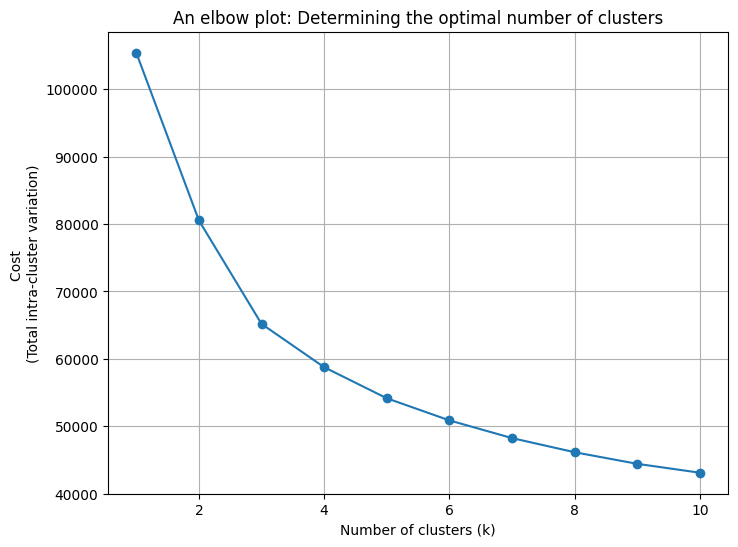

In [ ]:
### Construct an elbow plot

plt.figure(figsize = (8, 6))
plt.plot(number_of_clusters,
         cost,
         marker = 'o')
plt.title('An elbow plot: Determining the optimal number of clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost \n(Total intra-cluster variation)')
plt.grid(True)
plt.savefig(f'{file_path}/3_Figures/elbow plot.png')
plt.show()

**C. Cluster the observations using k-prototypes**


In [ ]:
### Extract the list of assigned clusters, at optimal k (= 4)
# Retrieve data based on the index (= optimal k - 1)
# Append the output of cluster analysis onto the original dataset
# Add 1 to each cluster label (so that labels start from 1, NOT 0)

recs['CLUSTER'] = np.array(assigned_clusters[3]) + 1

In [ ]:
### Save the results of the cluster analysis as .csv

recs.to_csv(f'{file_path}/1_Data/RECS_2020 (CLUSTERED).csv', index = False)

### **III. Data visualization**

**A. Create an *adjusted* measure of energy usage**


In [ ]:
### Construct a measure of energy use intensity (EUI)
### i.e. Energy consumption adjusted for the *size of home*

recs['EUI'] = recs['TOTAL_USAGE'] / recs['TOTAL_AREA']

### Construct a measure of energy consumption adjusted for *household size*
recs['TOTAL_USAGE_PER_PERSON'] = recs['TOTAL_USAGE'] / recs['HOUSEHOLD_SIZE']

**B. Visualize the size of the clusters**

In [ ]:
def plot_cluster_size(df):

  # Construct a dataframe
  data = df['CLUSTER'].value_counts().reset_index()

  # Create a bar plot
  plt.figure(figsize = (6, 4))
  sns.barplot(x = 'CLUSTER', y ='count', data = data)
  plt.xlabel('Cluster')
  plt.ylabel('Number of households')
  plt.title('Size of clusters', weight = 'bold')

  plt.savefig(f'{file_path}/3_Figures/cluster size.png')
  plt.show()

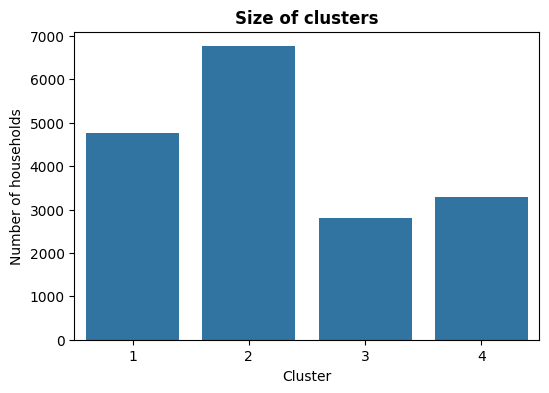

In [ ]:
plot_cluster_size(recs)

**C. Compare the characteristics of each cluster**

***Define functions that combine multiple bar plots***

In [ ]:
def plot_barchart_dual_axis(data, variable_1, variable_2,
                            axis_title_1, axis_title_2,
                            legend_1, legend_2, plot_title,
                            mean_2, space_2, annotation_2,
                            mean_1 = False, space_1 = False, annotation_1 = False, format_ticks = False):

    """
    Plots two variables on a horizontal bar chart
    with dual x-axes
    """
    ### Arrange the summary stats in reverse order of clusters (for plotting a *horizontal* bar chart)
    summary = data.groupby('CLUSTER')[[variable_1, variable_2]].mean().reset_index()
    summary = summary.sort_values(by = 'CLUSTER',
                                  ascending = False).reset_index(drop = True)

    fig, ax1 = plt.subplots()

    ### Y-axis (for clusters)
    ax1.set_ylabel('Cluster') # Axis title
    clusters = range(len(summary['CLUSTER'])) # location on the y-axis
    ax1.set_yticks(clusters)
    ax1.set_yticklabels(summary['CLUSTER'])

    ### Aesthetics for the bars
    adjustment = 0.15 # For realigning the bars with the y-ticks
    bar_width = 0.3 # Height of the horizontal bars

    """
    Plot Variable 1.
    Place the scale on the *bottom* x-axis (Red)
    """
    color_x1 = '#a50f15' # Red
    ax1.set_xlabel(axis_title_1, color = color_x1, weight = 'bold')
    ax1.barh([p - adjustment for p in clusters],
            summary[variable_1],
            color = '#e0802c', height = bar_width, label = legend_1)
    ax1.tick_params(axis = 'x', labelcolor = color_x1)


    """
    Plot Variable 2.
    Place the scale on the *top* x-axis (Blue)
    """
    ### Instantiate a second axes that shares the same y-axis
    ax2 = ax1.twiny()
    color_x2 = '#1565C0' # Blue
    ax2.set_xlabel(axis_title_2, color = color_x2, weight = 'bold')
    ax2.barh([p + bar_width - adjustment for p in clusters],
            summary[variable_2],
            color = '#3173a1', height = bar_width, label = legend_2)
    ax2.tick_params(axis = 'x', labelcolor = color_x2)
    ax2.axvline(mean_2, color = '#1e3f66', linestyle = '--', linewidth = 1)
    ax2.text(mean_2 + space_2, 1.5, f'{annotation_2}: {mean_2} ', color = '#1e3f66', verticalalignment = 'bottom', horizontalalignment = 'left')


    ### Add an option to format the tick labels
    if format_ticks:
      ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))

    ### Add an optional annotation to indicate the national average
    if mean_1:
      # Scale the national average to match the formatted x-axis
      scaled_mean_1 = mean_1 * 1000
      ax1.axvline(scaled_mean_1, color = '#8b0001', linestyle = '--', linewidth = 1)
      ax1.text(scaled_mean_1 + space_1, 1.3, f'{annotation_1}: {mean_1} ', color = '#8b0001', verticalalignment = 'bottom', horizontalalignment = 'right')

    ### Legend location & plot title
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper right')
    plt.title(plot_title, fontsize = 12, weight = 'bold', loc = 'left')
    plt.tight_layout()
    plt.savefig(f'{file_path}/3_Figures/{plot_title}.png')
    plt.show()


In [ ]:
def plot_barcharts_side_by_side(columns, x_axis_labels, means, file_name):

  """
  Plots 2 horizontal bar charts next to each other
  """
  fig, axes = plt.subplots(1, 2, figsize = (9, 4))
  axes = axes.flatten()

  # Define a yellow-orange-brown palette
  cmap = sns.color_palette('YlOrBr', n_colors = 4)

  # For each column and its corresponding axis
  for i, (ax, column, label, mean) in enumerate(zip(axes, columns, x_axis_labels, means)):

      # Calculate the mean of the column for each cluster
      grouped_data = recs.groupby('CLUSTER')[column].mean().reset_index()

      # Sort the data to apply darker colors to larger values
      grouped_data_sorted = grouped_data.sort_values(by = column, ascending = False)

      # Create the horizontal bar plot
      sns.barplot(x = column, y = 'CLUSTER', data = grouped_data_sorted,
                  ax = ax, orient = 'h',
                  hue = column, palette = cmap, legend = False)
      ax.set_ylabel('Cluster')
      ax.set_xlabel(label, weight = 'bold')

      # [For the left-hand plot] Format the axis ticks & indicate the national average
      if i == 0:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))

        # Scale the national average to match the formatted x-axis
        scaled_mean = mean * 1000
        ax.axvline(scaled_mean, linestyle = '--', linewidth = 1, color = 'black')
        ax.text(1.03 * scaled_mean + 10, 3.3, f'U.S. Average: \n{mean} ', verticalalignment = 'bottom', horizontalalignment = 'left', color = 'black')

      # [For the left-hand plot] Use the original scale & indicate the national average
      else:
        ax.axvline(mean, linestyle = '--', linewidth = 1, color = 'black')
        ax.text(mean + 1, 1.3, f'U.S. Average: \n{mean}', verticalalignment = 'bottom', horizontalalignment = 'left', color = 'black')


  plt.tight_layout(rect = [0, 0, 1, 0.95])
  fig.suptitle('Energy usage (unadjusted vs. adjusted):', fontsize = 12, weight = 'bold')
  fig.subplots_adjust(wspace = 0.125)
  plt.savefig(f'{file_path}/3_Figures/{file_name}.png')
  plt.show()

In [ ]:
def plot_stacked_barchart(column, plot_title):

  '''
  Create a stacked barplot for continuous variables.
  '''

  # Calculate the % of each category within a given column, by cluster
  pct = recs.groupby('CLUSTER')[column].value_counts(normalize = True).mul(100).round(2).rename('PERCENTAGE').reset_index()


  # Rearrange the order of the categories (NOT in alphabetical order)
  order_dict = {
      'INCOME': ['Low', 'Middle', 'High'],
      'EDUCATION': ["No Bachelor's degree", "Bachelor's degree or higher"],
      'RACE_ETHNIC': ['Hispanic/Latino/Black/Other ethnic minorities', 'White (Non-Hispanic)', 'Asian (Non-Hispanic)']}

  order = order_dict.get(column, None)

  if order:
    pct[column] = pd.Categorical(pct[column], categories = order, ordered = True)

  # Pivot wider for ease of visualization
  pivot_data = pct.pivot(index = 'CLUSTER', columns = column, values = 'PERCENTAGE')

  # Plot a stacked bar chart
  fig, ax = plt.subplots(figsize = (8, 6))
  stacked_bars = pivot_data.plot(kind = 'bar', stacked = True, ax = ax, edgecolor = 'black')
  ax.set_ylabel('Percentage (%)')
  ax.set_xlabel('Cluster')
  ax.set_title(plot_title, fontsize = 12, weight = 'bold', loc = 'left')
  plt.xticks(rotation = 0)
  stacked_bars.legend(loc = 'upper right')
  stacked_bars.legend_.set_title(None)

  # Annotate each bar
  for c in ax.containers:
    labels = [str(round(v.get_height())) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type = 'center',
                 labels = labels,
                 size = 8)

  plt.savefig(f'{file_path}/3_Figures/{plot_title}.png')
  plt.show()

***a) Examine climatic differences across clusters***

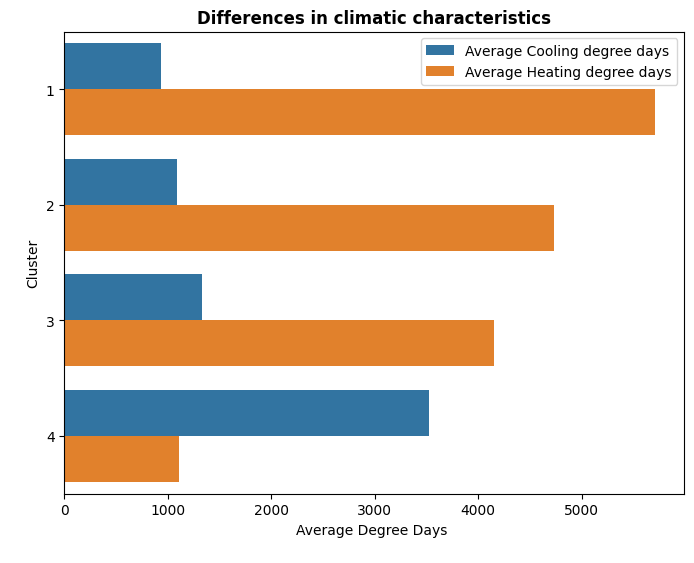

In [ ]:
# Calculate the mean of each variable, by cluster label
summary = recs.groupby('CLUSTER')[['COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS']].mean().reset_index()

# Pivot longer for ease of plotting
plot_data = pd.melt(summary,
                    id_vars = ['CLUSTER'],
                    value_vars = ['COOLING_DEGREE_DAYS', 'HEATING_DEGREE_DAYS'],
                    var_name = 'Variable', value_name = 'Mean')

# Edit the legend labels (remove underscores and capitalize each word)
plot_data['Variable'] = 'Average ' + plot_data['Variable'].str.replace('_', ' ').str.capitalize()

# Create a single bar plot that visualizes data for multiple variables
plt.figure(figsize = (8, 6))
bar_plot = sns.barplot(x = 'Mean', y = 'CLUSTER', hue = 'Variable', data = plot_data, orient = 'h')
plt.ylabel('\nCluster')
plt.xlabel('Average Degree Days \n')
plt.title('Differences in climatic characteristics', fontsize = 12, weight = 'bold')
bar_plot.legend_.set_title(None)
plt.savefig(f'{file_path}/3_Figures/climatic characteristics.png')
plt.show()

***b) Compare average size of home and size of household***

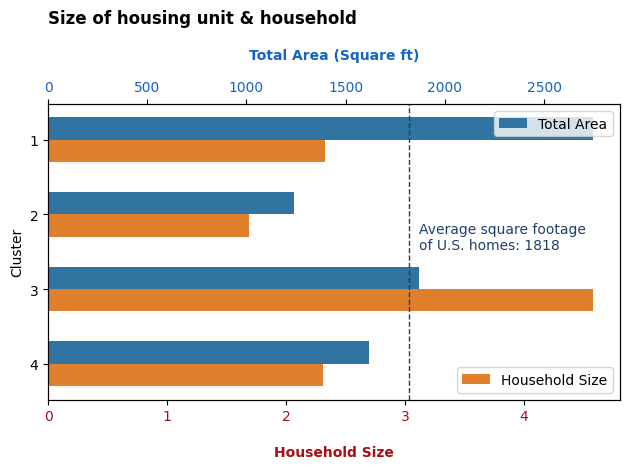

In [ ]:
plot_barchart_dual_axis(
    recs,
    'HOUSEHOLD_SIZE', 'TOTAL_AREA',
    '\nHousehold Size', '\nTotal Area (Square ft)\n',
    'Household Size', 'Total Area',
    'Size of housing unit & household',
    1818, 50, 'Average square footage \nof U.S. homes')

***c) Compare average energy usage (adjusted)***

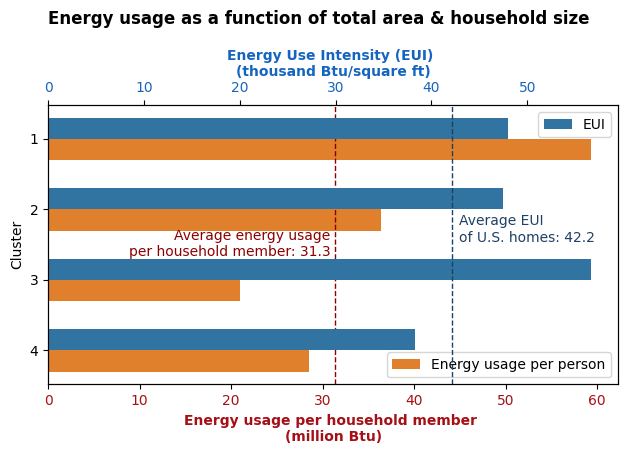

In [ ]:
plot_barchart_dual_axis(
    recs,
    'TOTAL_USAGE_PER_PERSON', 'EUI',
    'Energy usage per household member \n(million Btu)\n', '\nEnergy Use Intensity (EUI) \n(thousand Btu/square ft)',
    'Energy usage per person', 'EUI',
    'Energy usage as a function of total area & household size',
    42.2, 0.7, 'Average EUI \nof U.S. homes',
    31.3, 8, 'Average energy usage \nper household member', format_ticks = True)

***d) Compare average energy usage (adjusted & unadjusted)***

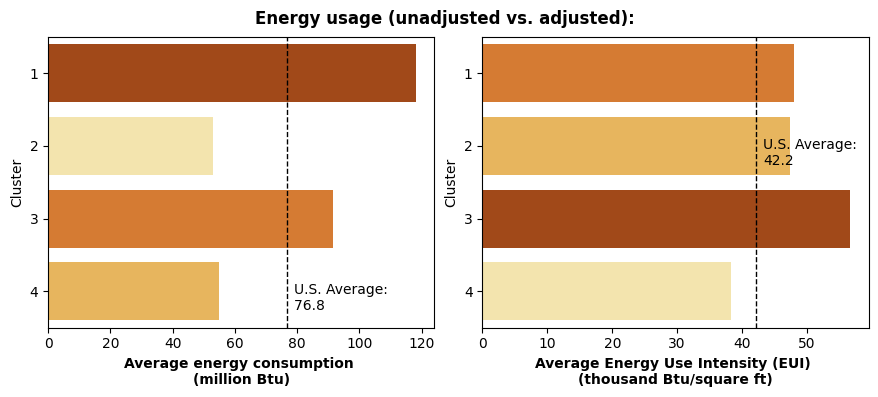

In [ ]:
variables_to_compare = ['TOTAL_USAGE', 'EUI']
x_axis_labels = ['Average energy consumption \n(million Btu)', 'Average Energy Use Intensity (EUI) \n(thousand Btu/square ft)']
means = [76.8, 42.2]

plot_barcharts_side_by_side(variables_to_compare, x_axis_labels, means, 'Energy usage (unadjusted & adjusted)')

***e) Compare the extent of insulation***

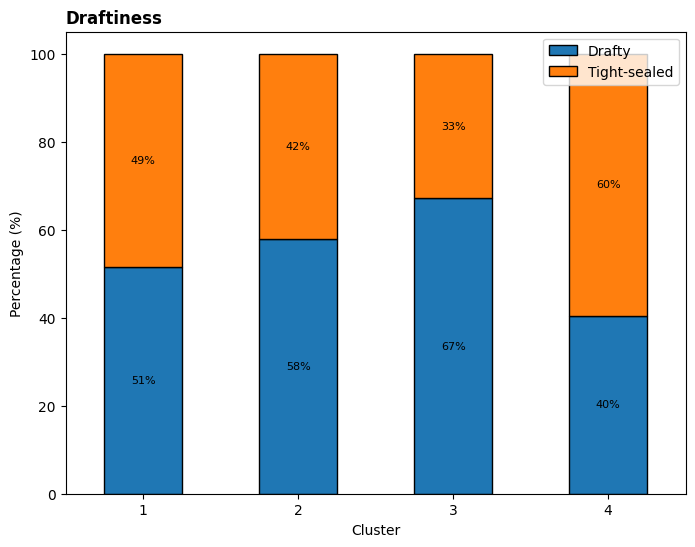

In [ ]:
plot_stacked_barchart('DRAFTY', 'Draftiness')

***f) Compare the levels of income***

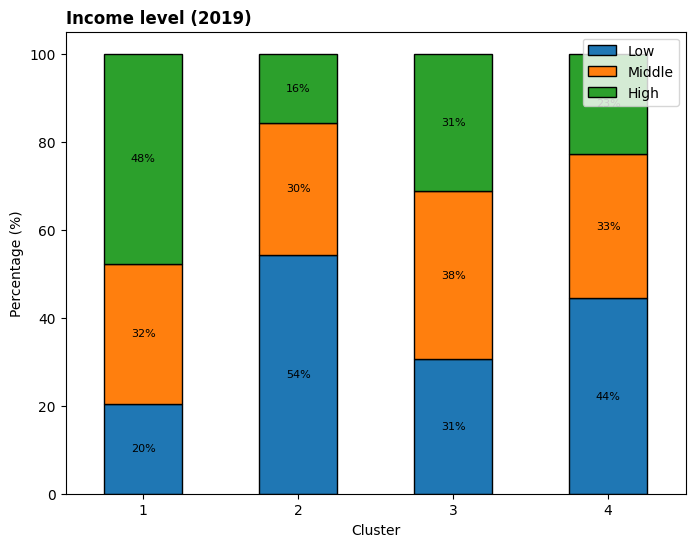

In [ ]:
plot_stacked_barchart('INCOME', 'Income level (2019)')

***g) Compare the extent of energy insecurity***

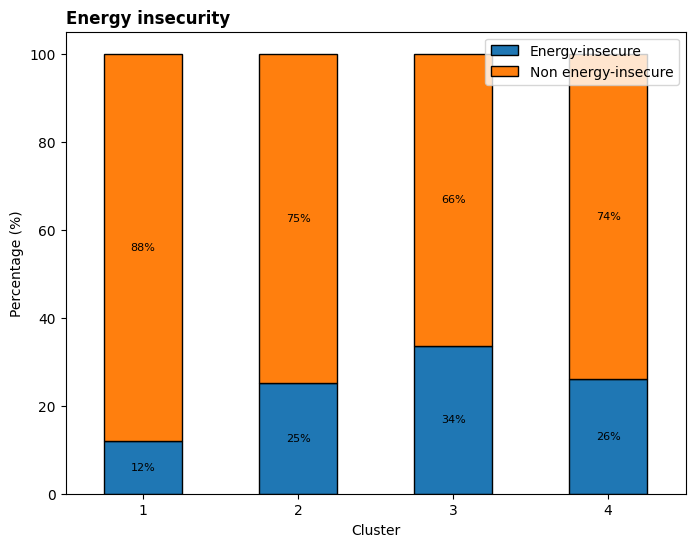

In [ ]:
plot_stacked_barchart('ENERGY_INSECURE', 'Energy insecurity')

***h) Compare the levels of education***

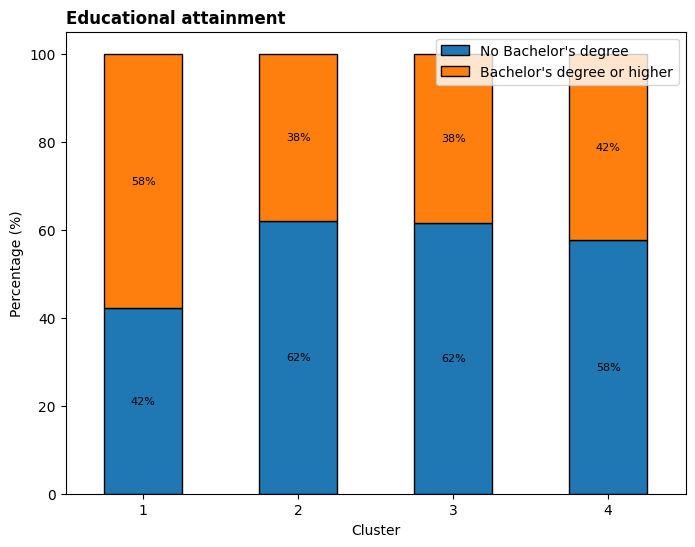

In [ ]:
plot_stacked_barchart('EDUCATION', 'Educational attainment')

***i) Compare race and ethnicity***

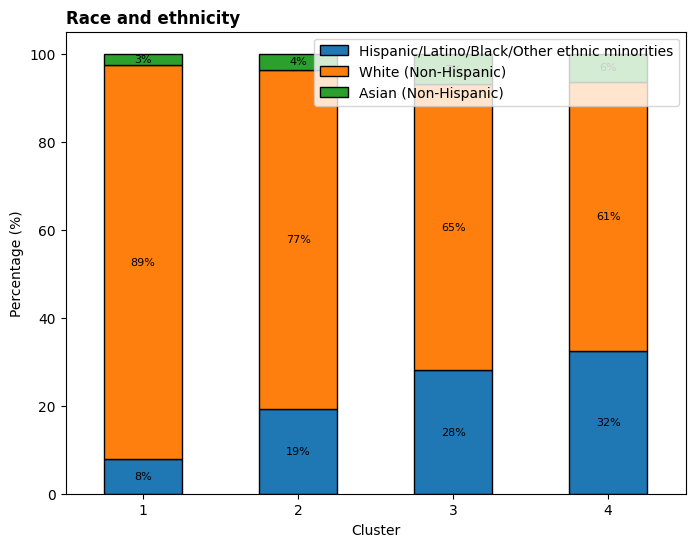

In [ ]:
plot_stacked_barchart('RACE_ETHNIC', 'Race and ethnicity')

### **IV. Track carbon emissions**


In [ ]:
### Display the amount of carbon emissions

emissions: float = tracker.stop()
print(f"Emissions: {emissions} kg")

[codecarbon INFO @ 05:20:51] Energy consumed for RAM : 0.007695 kWh. RAM Power : 4.753037452697754 W
[codecarbon INFO @ 05:20:51] Energy consumed for all CPUs : 0.069008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:20:51] 0.076704 kWh of electricity used since the beginning.


Emissions: 0.05661974624469332 kg
